# TF-MoDISco on the Nanog GkmExplain Scores, but without MEME init

Like the TF MoDISco Nanog notebook, but lacking the MEME cluster initialization step.

In [3]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [4]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip -f positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip -f gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_dnshuff_hypimpscores.txt.gz -O gkmexplain_dnshuff_hypimpscores.txt.gz
!gunzip -f gkmexplain_dnshuff_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/dnshuff_seqs.fa.gz -O dnshuff_seqs.fa.gz
!gunzip -f dnshuff_seqs.fa.gz

--2021-03-07 15:44:06--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: ‘positives_test.fa.gz’

positives_test.fa.g 100%[===================>]  73.28K  --.-KB/s    in 0.08s   

2021-03-07 15:44:07 (916 KB/s) - ‘positives_test.fa.gz’ saved [75038/75038]

--2021-03-07 15:44:07--  https://raw.githubusercontent.com/AvantiShri/model_storage/88a1527/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

### Read in the one-hot encoded sequences and scores

In [5]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def read_in_seqs_and_scores(fa_file, hypimpscores_file):
    seqs = [x.rstrip() for (i,x) in enumerate(open(fa_file)) if i%2==1]
    #filter out any sequences that contain 'N's
    onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                   for x in seqs if ('N' not in x)]
    #read in the hypothetical importance scores,
    # filter out any sequences that contain 'N's
    unnorm_hyp_impscores = [w[0] for w in zip([
        np.array( [[float(z) for z in y.split(",")]
            for y in x.rstrip().split("\t")[2].split(";")])
        for x in open(hypimpscores_file)],seqs)
        if 'N' not in w[1]]
    #in the original GkmExplain paper, a normalization of the
    # importance scores and hypothetical importance scores was
    # proposed, as this was empirically observed to improve
    # the signal-to-noise ratio. Here, I will do a
    # similar-in-spirit normalization that also appears to
    # improve the signal-to-noise ratio, but which is more
    # intuitive and better-motivated than the normalization
    # from the gkmexplain paper (the reason I didn't propose it
    # in that paper is simply that I hadn't considered it).
    #The normalization consists of subtracting the mean
    # hypothetical importance across ACGT at each position such
    # that the sum of the hypothetical importance at each position
    # is 0. The intuition is that this highlights the impact of
    # each base on the output **relative to the other bases that
    # could have been present**. The normalized actual importance
    # is simply the normalized hypothetical importance multiplied
    # by the one-hot encoding.
    hyp_impscores = [x - np.mean(x, axis=-1)[:,None] for x in unnorm_hyp_impscores]
    impscores = [x*y for x,y in zip(hyp_impscores, onehot_data)]
    
    return onehot_data, hyp_impscores, impscores
    

onehot_data, hyp_impscores, impscores = read_in_seqs_and_scores(
    fa_file="positives_test.fa",
    hypimpscores_file="gkmexplain_positives_hypimpscores.txt")
print("Num onehot sequences:",len(onehot_data))

_, _, nulldist_impscores = read_in_seqs_and_scores(
    fa_file="dnshuff_seqs.fa",
    hypimpscores_file="gkmexplain_dnshuff_hypimpscores.txt")
nulldist_perposimp = np.sum(nulldist_impscores, axis=-1)

Num onehot sequences: 960


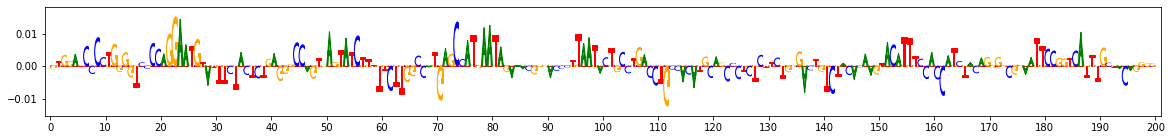

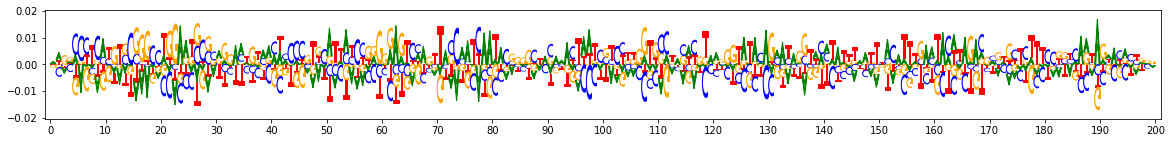

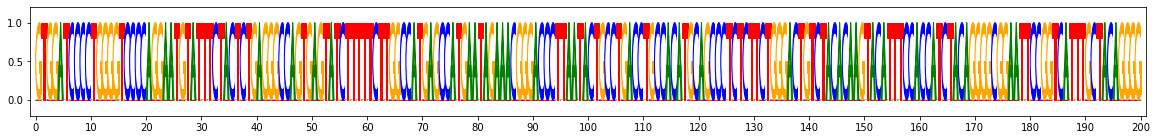

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

MEMORY 0.212361216
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold
For increasing = True , the minimum IR precision was 0.28762191141268867 occurring at 1.1961500000490233e-06 implying a frac_neg of 0.40374895862260485
To be conservative, adjusted frac neg is 0.95
For increasing = False , the minimum IR precision was 0.4829015187051677 occurring at -5.614999999965353e-07 implying a frac_neg of 0.9338676019623297
To be conservative, adjusted frac neg is 0.95
Thresholds from null dist were -0.21752344639999993  and  0.15626441020500015 with frac passing 0.07338541666666666
Final raw thresholds are -0.21752344639999993  and  0.15626441020500015
Final transformed thresholds are -0.9723900462962963  and  0.9213773148148148


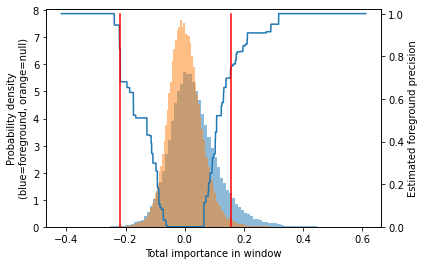

Got 923 coords
After resolving overlaps, got 923 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9212773148148148
MEMORY 0.301981696
923 identified in total
1 activity patterns with support >= 100 out of 2 possible patterns
Metacluster sizes:  [903]
Idx to activities:  {0: '1'}
MEMORY 0.302022656
On metacluster 0
Metacluster size 903
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
Using pynnd for nearest neighbor cosine sims
2021-12-08 16:47:17.710297 TfModiscoSeqletsToPatternsFactory: seed=1234
2021-12-08 16:47:17.773706 (Round 1) num seqlets: 903
2021-12-08 16:47:17.773962 (Round 1) Computing coarse affmat
MEMORY 0.302022656
Beginning embedding computation
MEMORY 0.302022656
At the beginning of embedding call
MEMORY 0.302022656
before computing embeddings fwd
MEMORY 0.302026752


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 332 tasks      | elapsed:    9.4s
[Parallel(n_jobs=4)]: Done 832 tasks      | elapsed:   19.7s
[Parallel(n_jobs=4)]: Done 896 out of 903 | elapsed:   21.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done 903 out of 903 | elapsed:   21.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


after computing embeddings fwd
MEMORY 0.315203584


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   19.1s
[Parallel(n_jobs=4)]: Done 903 out of 903 | elapsed:   19.8s finished


after computing embeddings rev
MEMORY 0.338804736
before computing sparse embeddings fwd
MEMORY 0.338804736
Constructing csr matrix...
csr matrix made in 0.12334513664245605 s
after computing sparse embeddings fwd
MEMORY 0.36937728
before computing sparse embeddings rev
MEMORY 0.36937728
Constructing csr matrix...
csr matrix made in 0.1338670253753662 s
after computing sparse embeddings rev
MEMORY 0.389251072
Finished embedding computation in 41.54 s
MEMORY 0.389251072
Starting affinity matrix computations
MEMORY 0.389251072
2021-12-08 16:48:02.242400 Building the index


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


2021-12-08 16:48:13.466033 Preparing the index
2021-12-08 16:48:21.941922 Index ready
2021-12-08 16:48:21.942521 Querying neighbors for fwd
2021-12-08 16:48:23.273636 Querying neighbors for rev
2021-12-08 16:48:24.595446 Unifying fwd and rev
Finished affinity matrix computations in 25.33 s
MEMORY 0.481333248
2021-12-08 16:48:24.754758 (Round 1) Computed coarse affmat
MEMORY 0.481333248
2021-12-08 16:48:24.755797 (Round 1) Computing fine-grained affinity matrix
MEMORY 0.481333248
2021-12-08 16:48:24.835206 Building the index
Wed Dec  8 16:48:43 2021 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	 3  /  10
	 4  /  10
	 5  /  10
	Stopping threshold met -- exiting after 5 iterations
2021-12-08 16:55:46.986102 Preparing the index
Wed Dec  8 16:56:18 2021 Forward diversification reduced edges from 27090 to 6325
Wed Dec  8 16:56:43 2021 Reverse diversification reduced edges from 6325 to 6325
Wed Dec  8 16:56:43 2021 Degree pruning reduced edges from 7692 to 7692
Wed Dec  8 16:56:43 2021 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s


Quality: 0.5163272826374717
Quality: 0.5174375735765845
2021-12-08 16:59:18.410155 Got 5 clusters after round 1
Counts:
{2: 182, 4: 74, 0: 306, 1: 246, 3: 95}
MEMORY 1.654194176
2021-12-08 16:59:18.410829 (Round 1) Aggregating seqlets in each cluster
MEMORY 1.654194176
2021-12-08 16:59:18.411766 Aggregating for cluster 0 with 306 seqlets
MEMORY 1.654194176


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.6s finished


Skipped 1 seqlets that went over the sequence edge during flank expansion
Skipped 31 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 274
Skipped 25 seqlets that went over the sequence edge during flank expansion
2021-12-08 16:59:19.187781 Aggregating for cluster 1 with 246 seqlets
MEMORY 1.654198272
Skipped 3 seqlets that went over the sequence edge during flank expansion
Skipped 3 seqlets that went over the sequence edge during flank expansion
Skipped 22 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 218
Skipped 22 seqlets that went over the sequence edge during flank expansion
2021-12-08 16:59:19.800249 Aggregating for cluster 2 with 182 seqlets
MEMORY 1.654198272
Skipped 2 seqlets that went over the sequence edge during flank expansion
Skipped 21 seqlets that went over sequence edge during flank expansion
Trimming eliminated 0 seqlets out of 159
Skipped 11 seqlets that went over the se

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 710 tasks      | elapsed:   11.0s
[Parallel(n_jobs=4)]: Done 727 out of 727 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


after computing embeddings fwd
MEMORY 1.654358016


[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 716 tasks      | elapsed:   10.9s
[Parallel(n_jobs=4)]: Done 727 out of 727 | elapsed:   11.1s finished


after computing embeddings rev
MEMORY 1.654362112
before computing sparse embeddings fwd
MEMORY 1.654362112
Constructing csr matrix...
csr matrix made in 0.09423589706420898 s
after computing sparse embeddings fwd
MEMORY 1.657344
before computing sparse embeddings rev
MEMORY 1.657344
Constructing csr matrix...
csr matrix made in 0.09961915016174316 s
after computing sparse embeddings rev
MEMORY 1.6586752
Finished embedding computation in 22.66 s
MEMORY 1.6586752
Starting affinity matrix computations
MEMORY 1.6586752
2021-12-08 16:59:43.448187 Building the index
2021-12-08 16:59:47.263129 Preparing the index
2021-12-08 16:59:48.623952 Index ready
2021-12-08 16:59:48.624483 Querying neighbors for fwd
2021-12-08 16:59:49.826536 Querying neighbors for rev
2021-12-08 16:59:50.908048 Unifying fwd and rev
Finished affinity matrix computations in 7.5 s
MEMORY 1.661485056
2021-12-08 16:59:51.085993 (Round 2) Computed coarse affmat
MEMORY 1.661485056
2021-12-08 16:59:51.086886 (Round 2) Computin

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s


Quality: 0.48327202435581945
Quality: 0.48328618102367854
Quality: 0.48346933498765293
2021-12-08 17:12:30.503118 Got 4 clusters after round 2
Counts:
{0: 247, 3: 86, 2: 188, 1: 206}
MEMORY 2.501808128
2021-12-08 17:12:30.503823 (Round 2) Aggregating seqlets in each cluster
MEMORY 2.501808128
2021-12-08 17:12:30.505032 Aggregating for cluster 0 with 247 seqlets
MEMORY 2.501808128


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.8s finished


Skipped 3 seqlets that went over sequence edge during flank expansion
Skipped 3 due to duplicates
Trimming eliminated 0 seqlets out of 241
Skipped 19 seqlets that went over the sequence edge during flank expansion
2021-12-08 17:12:31.379920 Aggregating for cluster 1 with 206 seqlets
MEMORY 2.501808128
Skipped 6 seqlets that went over sequence edge during flank expansion
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 199
Skipped 15 seqlets that went over the sequence edge during flank expansion
2021-12-08 17:12:32.058522 Aggregating for cluster 2 with 188 seqlets
MEMORY 2.501808128
Skipped 2 seqlets that went over sequence edge during flank expansion
Skipped 3 due to duplicates
Trimming eliminated 0 seqlets out of 183
Skipped 9 seqlets that went over the sequence edge during flank expansion
2021-12-08 17:12:32.694973 Aggregating for cluster 3 with 86 seqlets
MEMORY 2.501808128
Skipped 1 seqlets that went over sequence edge during flank expansion
Skipped 2 due to duplic

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 222 out of 222 | elapsed:    0.2s finished


Beginning preprocessing + Leiden
Affmat shape: 222


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.9s


Quality: 0.19155068785115933
Quality: 0.19296101035434396
Quality: 0.19396049626034773
Quality: 0.19399634485718625
Got subclusters: Counter({0: 42, 1: 36, 2: 32, 3: 32, 4: 30, 5: 24, 6: 13, 7: 10, 8: 3})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.6s finished


Numbers for each pattern pre-subsample: [42, 36, 32, 32, 30, 24, 13, 10, 3]
Numbers after subsampling: [42, 36, 32, 32, 30, 24, 13, 10, 3]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.28803396224975586 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.2951352596282959 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.25899600982666016 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.26097774505615234 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.24273920059204102 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.19559597969055176 s
Computing sims for pattern 6
Computed sims for pattern 6 in 0.15529322624206543 s
Computing sims for pattern 7
Computed sims for pattern 7 in 0.13151788711547852 s
Computing sims for pattern 8
Computed sims for pattern 8 in 0.08140683174133301 s
Cluster sizes
[42 36 32 32 30 24 13 10  3]
Cross-contamination matrix:
[[1.   0.59 1.   0.47 0.89 0.57 0.31 0.82 0.16]
 [0.9

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 184 out of 184 | elapsed:    0.1s finished


[t-SNE] Computed conditional probabilities for sample 184 / 184
[t-SNE] Mean sigma: 0.372206
Beginning preprocessing + Leiden
Affmat shape: 184


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s


Quality: 0.22817142778934052
Quality: 0.22824245718411953
Quality: 0.22906196143427
Got subclusters: Counter({0: 62, 1: 46, 2: 25, 4: 20, 3: 20, 5: 11})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    4.9s finished


Numbers for each pattern pre-subsample: [62, 46, 25, 20, 20, 11]
Numbers after subsampling: [62, 46, 25, 20, 20, 11]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.2875521183013916 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.23067975044250488 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.15680789947509766 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.14701604843139648 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.14499211311340332 s
Computing sims for pattern 5
Computed sims for pattern 5 in 0.11258101463317871 s
Cluster sizes
[62 46 25 20 20 11]
Cross-contamination matrix:
[[1.   0.56 0.41 0.7  0.66 0.45]
 [0.83 1.   0.65 0.85 0.82 0.52]
 [0.77 0.8  1.   0.83 0.75 0.41]
 [0.81 0.71 0.57 1.   0.73 0.38]
 [0.75 0.61 0.43 0.68 1.   0.42]
 [0.91 0.78 0.54 0.71 0.85 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.87 0.78 0.87 0.85 0.8 ]
 [0.87 1.   0.84 0.89 0.87 0.76]
 [0.78 0.84 1.   0.82 0.74 0.62]
 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 174 out of 174 | elapsed:    0.1s finished


[t-SNE] Computed conditional probabilities for sample 174 / 174
[t-SNE] Mean sigma: 0.388247
Beginning preprocessing + Leiden
Affmat shape: 174


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.4s


Quality: 0.25635830137120647
Quality: 0.26540843555585825
Quality: 0.26552320973820004
Quality: 0.2657829587548081
Quality: 0.26626094715094606
Got subclusters: Counter({0: 64, 1: 56, 2: 39, 3: 15})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.2s finished


Numbers for each pattern pre-subsample: [64, 56, 39, 15]
Numbers after subsampling: [64, 56, 39, 15]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.2107682228088379 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.16499090194702148 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.16959095001220703 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.09890985488891602 s
Cluster sizes
[64 56 39 15]
Cross-contamination matrix:
[[1.   0.72 0.57 0.75]
 [0.8  1.   0.78 0.79]
 [0.49 0.62 1.   0.63]
 [0.8  0.75 0.77 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.83 0.65 0.82]
 [0.83 1.   0.77 0.82]
 [0.65 0.77 1.   0.78]
 [0.82 0.82 0.78 1.  ]]
Inspecting pattern 3 for spurious merging
[t-SNE] Computed conditional probabilities for sample 79 / 79
[t-SNE] Mean sigma: 0.563485
Beginning preprocessing + Leiden
Affmat shape: 79


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  79 out of  79 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.3s


Quality: 0.12851387754494112
Quality: 0.1292346993482206
Got subclusters: Counter({0: 25, 1: 24, 2: 17, 3: 13})
On merging iteration 1


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.1s finished


Numbers for each pattern pre-subsample: [25, 24, 17, 13]
Numbers after subsampling: [25, 24, 17, 13]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.10405564308166504 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.09760689735412598 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.0811619758605957 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.0751948356628418 s
Cluster sizes
[25 24 17 13]
Cross-contamination matrix:
[[1.   0.68 0.73 0.7 ]
 [0.61 1.   0.76 0.71]
 [0.43 0.51 1.   0.52]
 [0.54 0.62 0.66 1.  ]]
Pattern-to-pattern sim matrix:
[[1.   0.73 0.75 0.69]
 [0.73 1.   0.78 0.75]
 [0.75 0.78 1.   0.79]
 [0.69 0.75 0.79 1.  ]]
2021-12-08 17:13:00.734907 Merging on 14 clusters
MEMORY 2.5025536
On merging iteration 1
Numbers for each pattern pre-subsample: [206, 13, 3, 146, 25, 11, 64, 56, 39, 15, 25, 24, 17, 13]
Numbers after subsampling: [206, 13, 3, 146, 25, 11, 64, 56, 39, 15, 25, 24, 17, 13]
Computing sims for pattern 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 190 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 206 out of 206 | elapsed:    0.1s finished
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/avantishrikumar/anaconda3/envs/base2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed alt

[t-SNE] Iteration 50: error = 71.4731903, gradient norm = 0.4245801 (50 iterations in 0.083s)
[t-SNE] Iteration 100: error = 71.1884155, gradient norm = 0.4331941 (50 iterations in 0.078s)
[t-SNE] Iteration 150: error = 70.7515564, gradient norm = 0.4291781 (50 iterations in 0.087s)
[t-SNE] Iteration 200: error = 67.6383667, gradient norm = 0.4954144 (50 iterations in 0.081s)
[t-SNE] Iteration 250: error = 66.1006775, gradient norm = 0.4472841 (50 iterations in 0.074s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.100677
[t-SNE] Iteration 300: error = 1.0721638, gradient norm = 0.0070913 (50 iterations in 0.069s)
[t-SNE] Iteration 350: error = 0.7800770, gradient norm = 0.0028487 (50 iterations in 0.072s)
[t-SNE] Iteration 400: error = 0.7697322, gradient norm = 0.0011409 (50 iterations in 0.069s)
[t-SNE] Iteration 450: error = 0.7677428, gradient norm = 0.0002491 (50 iterations in 0.069s)
[t-SNE] Iteration 500: error = 0.7679994, gradient norm = 0.0001482 (50 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.4s


Quality: 0.18011950361612036
Quality: 0.18485935602303671
Quality: 0.18840955271842602
Quality: 0.1891851488963446
Quality: 0.18926380871565016


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 146 out of 146 | elapsed:    0.1s finished


Got subclusters: Counter({0: 48, 1: 39, 2: 34, 3: 34, 4: 19, 5: 14, 6: 13, 7: 5})
2021-12-08 17:13:20.756822 On pattern 1
[t-SNE] Computing 145 nearest neighbors...
[t-SNE] Indexed 146 samples in 0.002s...
[t-SNE] Computed neighbors for 146 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 146 / 146
[t-SNE] Mean sigma: 0.380170
[t-SNE] Computed conditional probabilities in 0.009s
[t-SNE] Iteration 50: error = 58.0838356, gradient norm = 0.5175662 (50 iterations in 0.053s)
[t-SNE] Iteration 100: error = 58.5895157, gradient norm = 0.4750588 (50 iterations in 0.057s)
[t-SNE] Iteration 150: error = 60.5718269, gradient norm = 0.5277138 (50 iterations in 0.047s)
[t-SNE] Iteration 200: error = 57.6833534, gradient norm = 0.4994000 (50 iterations in 0.049s)
[t-SNE] Iteration 250: error = 54.5890846, gradient norm = 0.5028236 (50 iterations in 0.050s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.589085
[t-SNE] Iteration 300: error = 0.6627244

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.1s


Quality: 0.21081740813965677
Quality: 0.2111236847732684


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed:    0.0s finished


Got subclusters: Counter({0: 43, 1: 35, 2: 27, 3: 26, 4: 15})
2021-12-08 17:13:28.050576 On pattern 2
[t-SNE] Computing 63 nearest neighbors...
[t-SNE] Indexed 64 samples in 0.001s...
[t-SNE] Computed neighbors for 64 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 64 / 64
[t-SNE] Mean sigma: 0.640353
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 46.2145042, gradient norm = 0.5586914 (50 iterations in 0.041s)
[t-SNE] Iteration 100: error = 46.4681854, gradient norm = 0.5857685 (50 iterations in 0.026s)
[t-SNE] Iteration 150: error = 44.5393753, gradient norm = 0.5974214 (50 iterations in 0.029s)
[t-SNE] Iteration 200: error = 52.0665627, gradient norm = 0.4290497 (50 iterations in 0.037s)
[t-SNE] Iteration 250: error = 47.6767578, gradient norm = 0.4105772 (50 iterations in 0.045s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.676758
[t-SNE] Iteration 300: error = 0.7927098, gradient norm = 0.00176

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s


Quality: 0.0875797791547207


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 out of  56 | elapsed:    0.0s finished


Got subclusters: Counter({0: 35, 1: 29})
2021-12-08 17:13:34.624601 On pattern 3
[t-SNE] Computing 55 nearest neighbors...
[t-SNE] Indexed 56 samples in 0.001s...
[t-SNE] Computed neighbors for 56 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 56 / 56
[t-SNE] Mean sigma: 0.857921
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 48.2739258, gradient norm = 0.5955712 (50 iterations in 0.029s)
[t-SNE] Iteration 100: error = 43.8776360, gradient norm = 0.5243885 (50 iterations in 0.032s)
[t-SNE] Iteration 150: error = 43.3978729, gradient norm = 0.5942596 (50 iterations in 0.030s)
[t-SNE] Iteration 200: error = 44.1111679, gradient norm = 0.3884238 (50 iterations in 0.032s)
[t-SNE] Iteration 250: error = 44.2955704, gradient norm = 0.5800033 (50 iterations in 0.034s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.295570
[t-SNE] Iteration 300: error = 0.7870031, gradient norm = 0.0013321 (50 iterations in 

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s


Quality: 0.03762343637550438
Quality: 0.037860586300187425


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  39 out of  39 | elapsed:    0.0s finished


Got subclusters: Counter({0: 26, 1: 16, 2: 14})
2021-12-08 17:13:41.065450 On pattern 4
[t-SNE] Computing 38 nearest neighbors...
[t-SNE] Indexed 39 samples in 0.001s...
[t-SNE] Computed neighbors for 39 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 39 / 39
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.003s
[t-SNE] Iteration 50: error = 44.2483749, gradient norm = 0.4945828 (50 iterations in 0.036s)
[t-SNE] Iteration 100: error = 45.4104004, gradient norm = 0.7136114 (50 iterations in 0.022s)
[t-SNE] Iteration 150: error = 43.6024742, gradient norm = 0.5523239 (50 iterations in 0.019s)
[t-SNE] Iteration 200: error = 42.3340378, gradient norm = 0.5608702 (50 iterations in 0.029s)
[t-SNE] Iteration 250: error = 41.9471130, gradient norm = 0.4509972 (50 iterations in 0.030s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.947113
[t-SNE] Iteration 300: error = 0.6240058, gradient norm = 0.0009

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s


Quality: 4.0412118096357004e-14


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Got subclusters: Counter({0: 39})
2021-12-08 17:13:47.463033 On pattern 5
[t-SNE] Computing 24 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.001s...
[t-SNE] Computed neighbors for 25 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 48.3642426, gradient norm = 0.4966776 (50 iterations in 0.021s)
[t-SNE] Iteration 100: error = 51.4994125, gradient norm = 0.5245329 (50 iterations in 0.027s)
[t-SNE] Iteration 150: error = 41.6517601, gradient norm = 0.7918428 (50 iterations in 0.025s)
[t-SNE] Iteration 200: error = 47.2219276, gradient norm = 0.3785344 (50 iterations in 0.024s)
[t-SNE] Iteration 250: error = 41.7042084, gradient norm = 0.6758102 (50 iterations in 0.025s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.704208
[t-SNE] Iteration 300: error = 0.7896508, gradient norm = 0.0010434 (50 iterat

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s


Quality: -1.332267629550175e-14


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.0s finished


Got subclusters: Counter({0: 25})
2021-12-08 17:13:53.871034 On pattern 6
[t-SNE] Computing 24 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.001s...
[t-SNE] Computed neighbors for 25 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 48.3642426, gradient norm = 0.4966776 (50 iterations in 0.031s)
[t-SNE] Iteration 100: error = 51.4994125, gradient norm = 0.5245329 (50 iterations in 0.020s)
[t-SNE] Iteration 150: error = 41.6517601, gradient norm = 0.7918428 (50 iterations in 0.019s)
[t-SNE] Iteration 200: error = 47.2219276, gradient norm = 0.3785344 (50 iterations in 0.023s)
[t-SNE] Iteration 250: error = 41.7042084, gradient norm = 0.6758102 (50 iterations in 0.030s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.704208
[t-SNE] Iteration 300: error = 0.7896508, gradient norm = 0.0010434 (50 iterat

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s


Quality: -1.332267629550175e-14


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed:    0.0s finished


Got subclusters: Counter({0: 25})
2021-12-08 17:14:00.201185 On pattern 7
[t-SNE] Computing 23 nearest neighbors...
[t-SNE] Indexed 24 samples in 0.001s...
[t-SNE] Computed neighbors for 24 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 24 / 24
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 49.2344131, gradient norm = 0.5288350 (50 iterations in 0.028s)
[t-SNE] Iteration 100: error = 50.6861191, gradient norm = 0.5744531 (50 iterations in 0.026s)
[t-SNE] Iteration 150: error = 45.8535538, gradient norm = 0.6550605 (50 iterations in 0.030s)
[t-SNE] Iteration 200: error = 44.3336411, gradient norm = 0.3698129 (50 iterations in 0.026s)
[t-SNE] Iteration 250: error = 48.0599976, gradient norm = 0.5015129 (50 iterations in 0.026s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.059998
[t-SNE] Iteration 300: error = 0.4756823, gradient norm = 0.0007955 (50 iterat

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s


Quality: 6.03961325396083e-14
Got subclusters: Counter({0: 24})


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished


In [6]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    use_louvain=False,
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    final_min_cluster_size=20,
                    #setting use_pynnd=True uses pynndescent in both
                    # the coarse and fine-grained steps.
                    # However, pynndescent can be
                    # finicky (e.g. it can run into errors when run on google colab;
                    # see https://github.com/lmcinnes/pynndescent/issues/133)
                    use_pynnd=True
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [7]:
import h5py
import modisco.util
reload(modisco.util)
! [[ -e results.hdf5 ]] && rm results.hdf5
grp = h5py.File("results.hdf5", "w")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


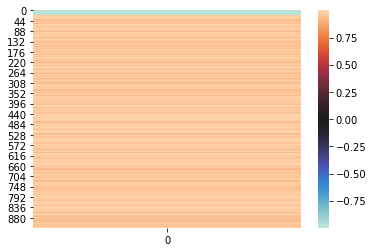

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 206
Hypothetical scores:


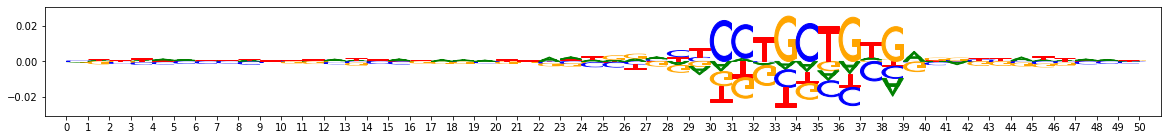

Actual importance scores:


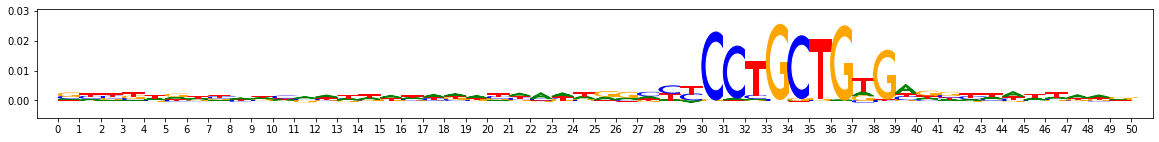

onehot, fwd and rev:


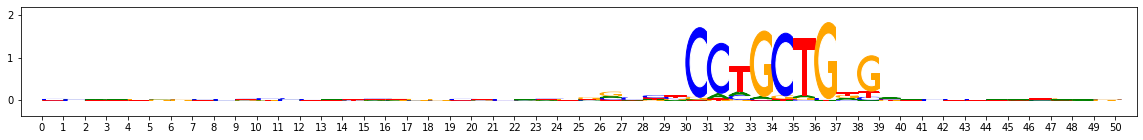

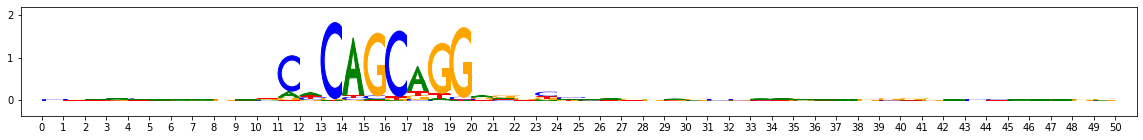

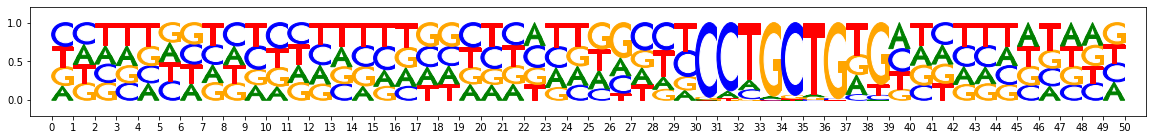

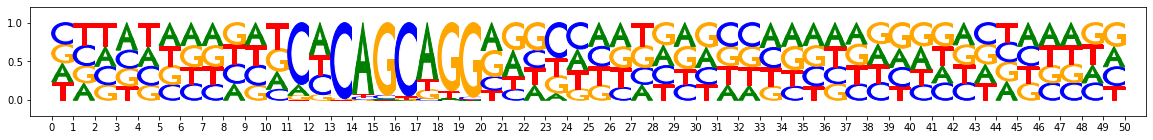

metacluster_0 pattern_1
total seqlets: 146
Hypothetical scores:


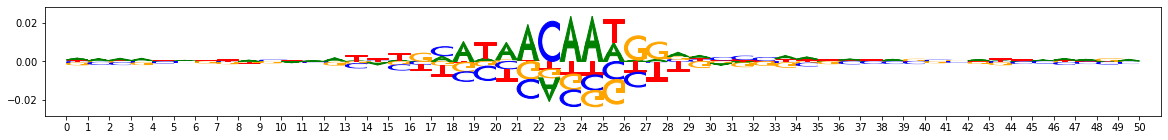

Actual importance scores:


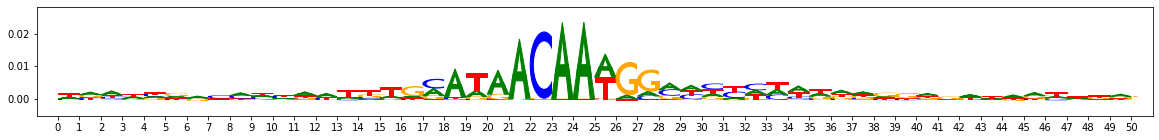

onehot, fwd and rev:


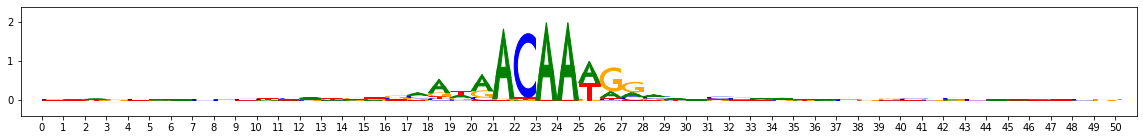

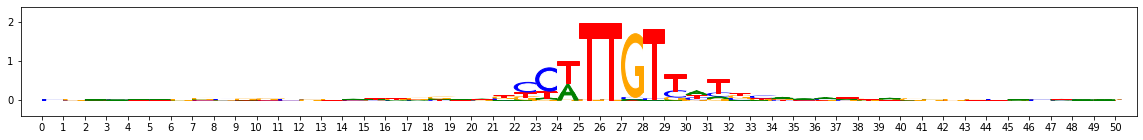

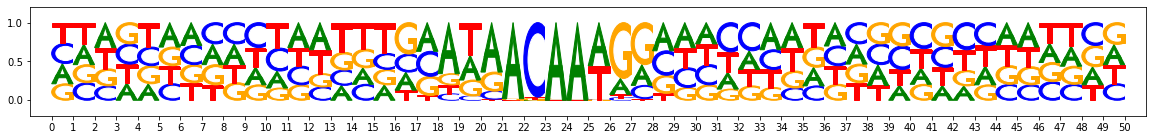

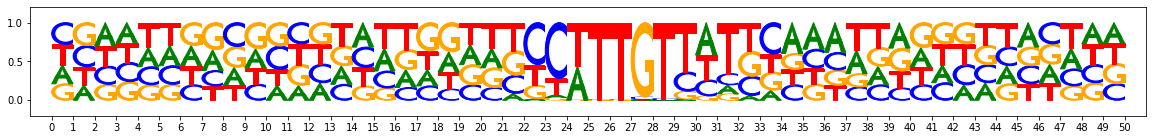

metacluster_0 pattern_2
total seqlets: 64
Hypothetical scores:


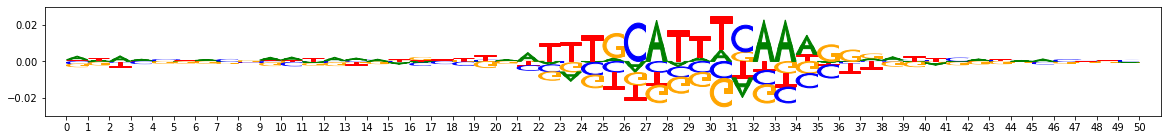

Actual importance scores:


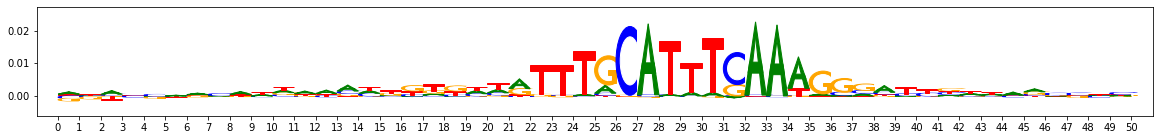

onehot, fwd and rev:


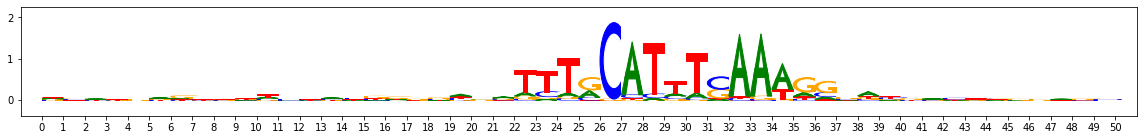

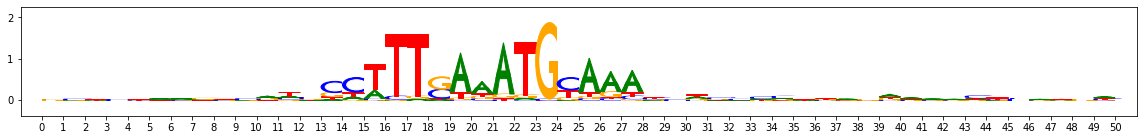

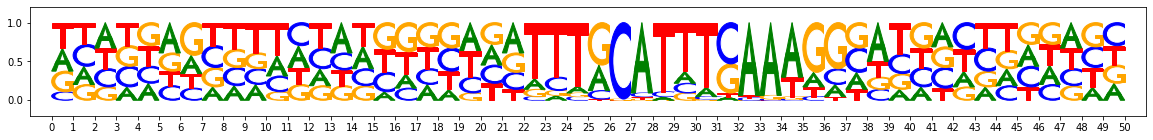

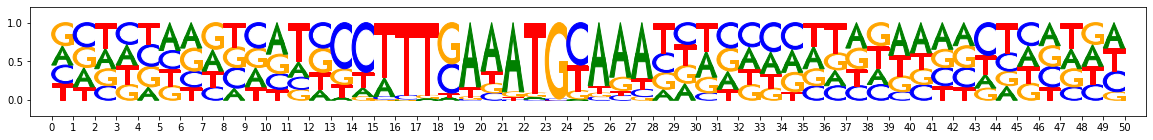

metacluster_0 pattern_3
total seqlets: 56
Hypothetical scores:


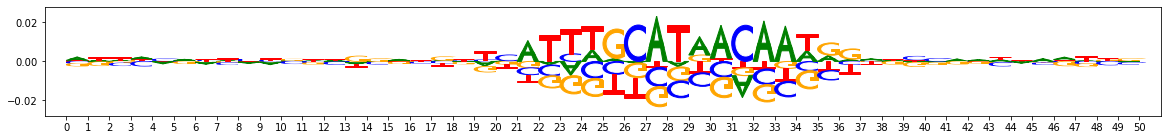

Actual importance scores:


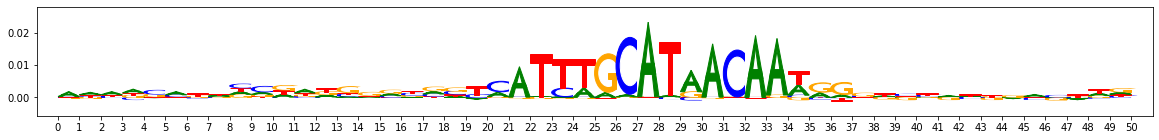

onehot, fwd and rev:


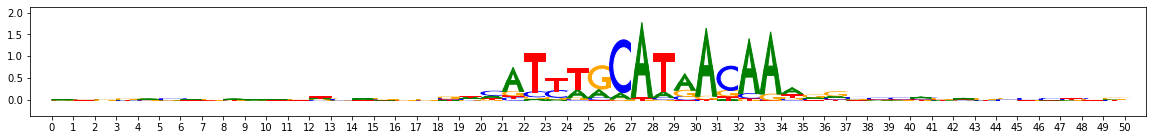

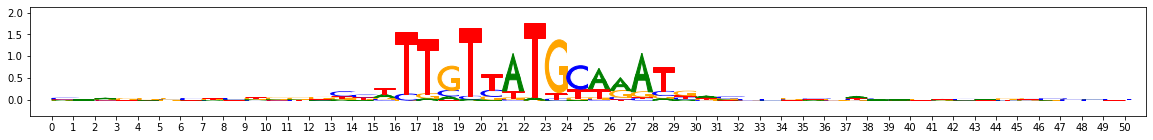

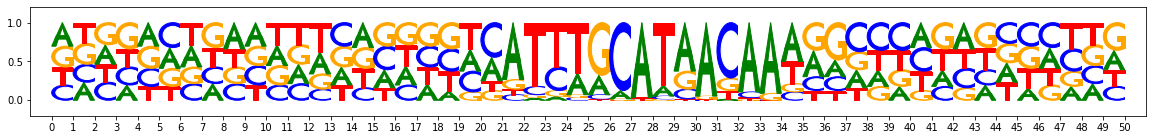

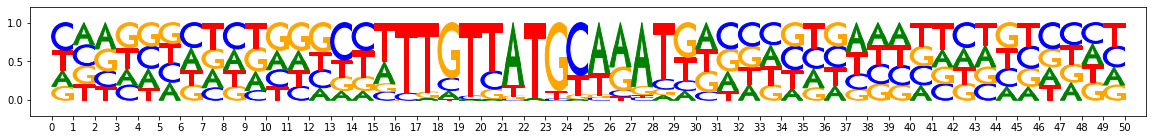

metacluster_0 pattern_4
total seqlets: 39
Hypothetical scores:


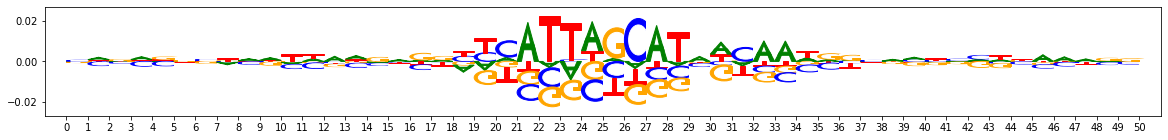

Actual importance scores:


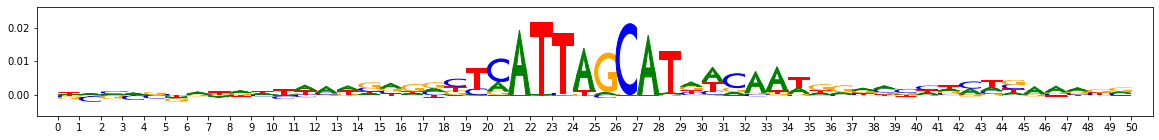

onehot, fwd and rev:


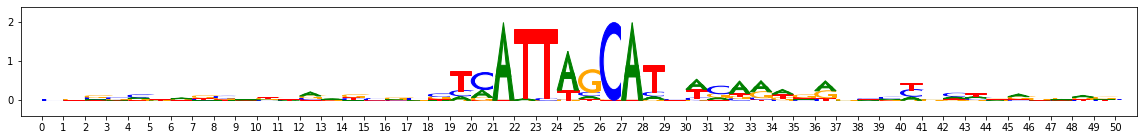

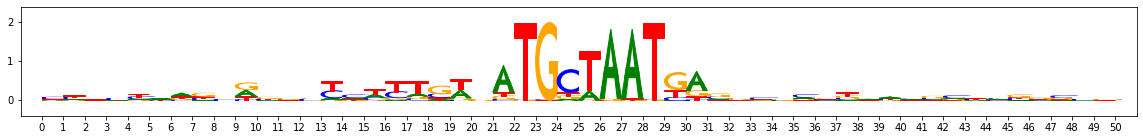

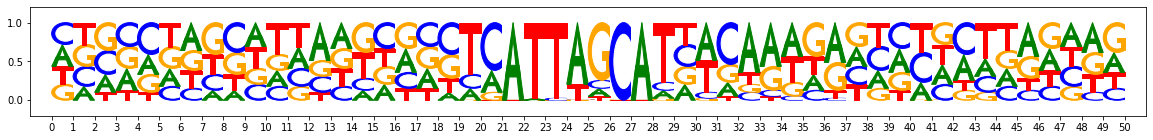

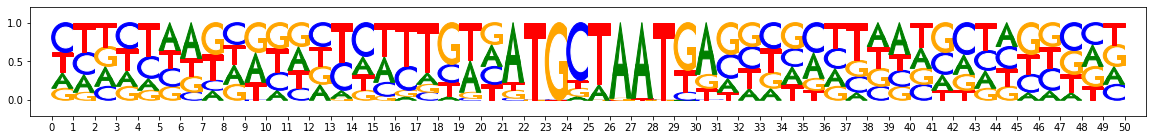

metacluster_0 pattern_5
total seqlets: 25
Hypothetical scores:


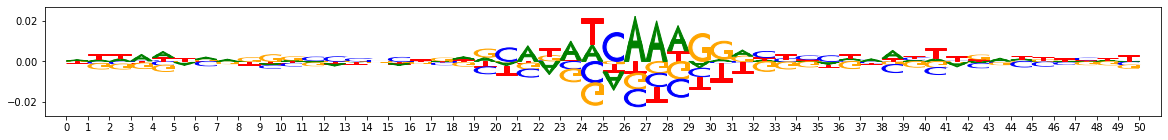

Actual importance scores:


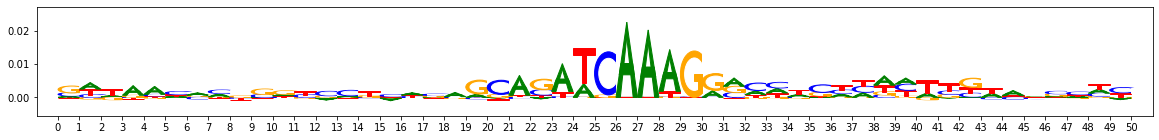

onehot, fwd and rev:


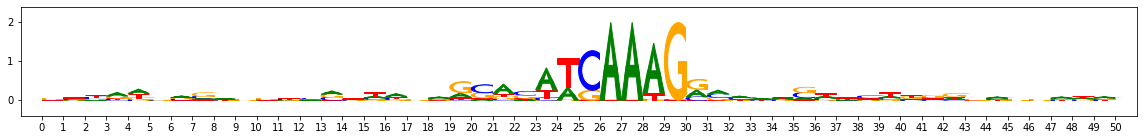

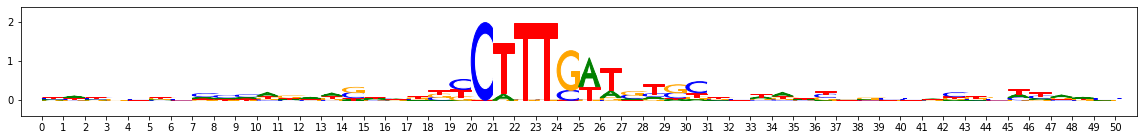

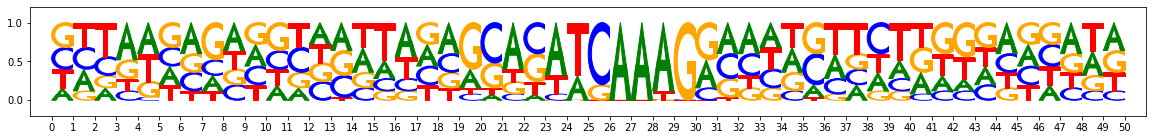

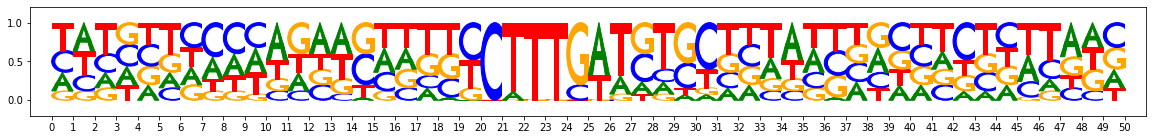

metacluster_0 pattern_6
total seqlets: 25
Hypothetical scores:


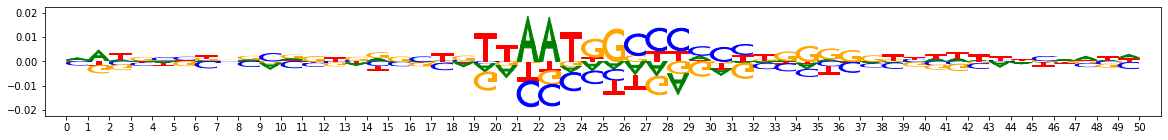

Actual importance scores:


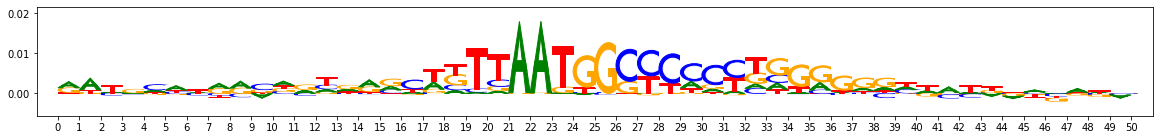

onehot, fwd and rev:


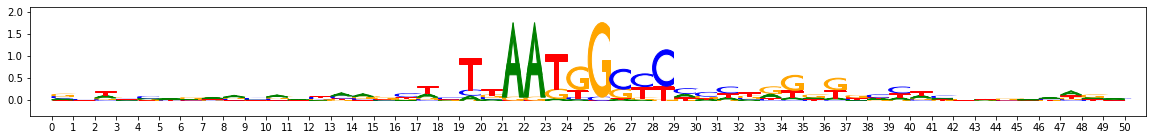

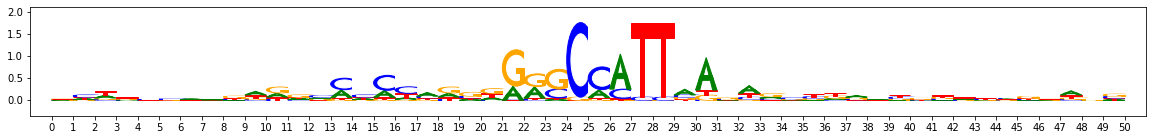

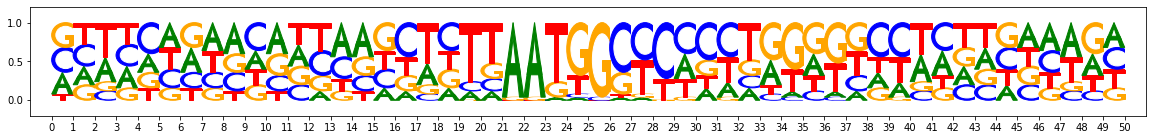

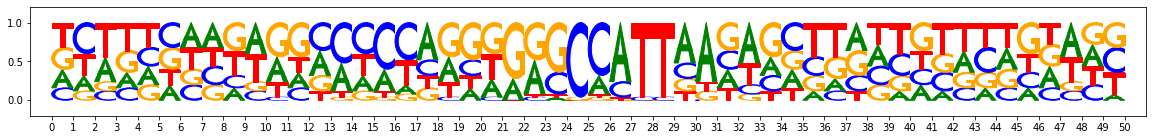

metacluster_0 pattern_7
total seqlets: 24
Hypothetical scores:


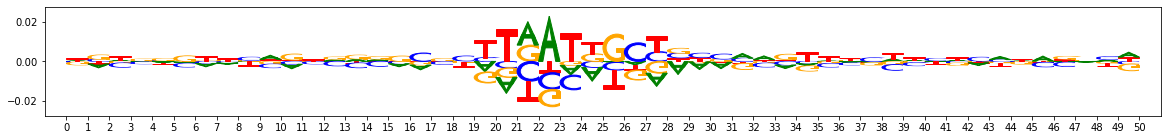

Actual importance scores:


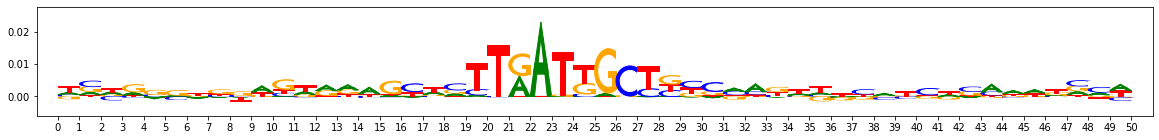

onehot, fwd and rev:


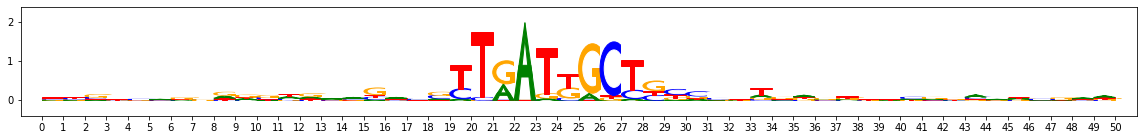

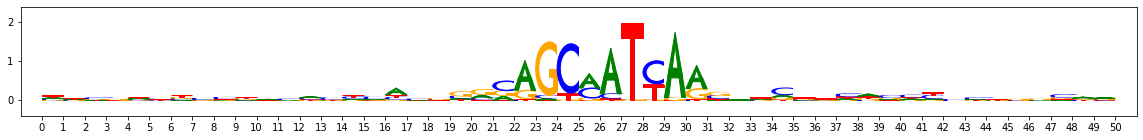

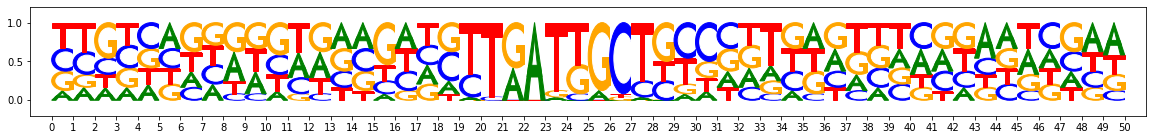

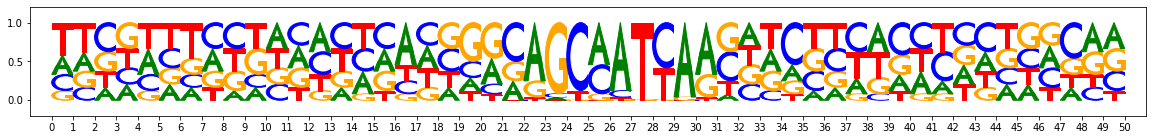

In [8]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5", "r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background))
        viz_sequence.plot_weights(pattern["sequence"]["fwd"]) 
        viz_sequence.plot_weights(pattern["sequence"]["rev"]) 
        
        ##Plot the subclustering too, if available
        #if ("subclusters" in pattern):
        #    print("PLOTTING SUBCLUSTERS")
        #    subclusters = np.array(pattern["subclusters"])
        #    twod_embedding = np.array(pattern["twod_embedding"])
        #    plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=subclusters, cmap="tab20")
        #    plt.show()
        #    for subcluster_name in list(pattern["subcluster_to_subpattern"]["subcluster_names"]):
        #        subpattern = pattern["subcluster_to_subpattern"][subcluster_name]
        #        print(subcluster_name.decode("utf-8"), "size", len(subpattern["seqlets_and_alnmts"]["seqlets"]))
        #        subcluster = int(subcluster_name.decode("utf-8").split("_")[1])
        #        plt.scatter(twod_embedding[:,0], twod_embedding[:,1], c=(subclusters==subcluster))
        #        plt.show()
        #        viz_sequence.plot_weights(subpattern["task0_hypothetical_contribs"]["fwd"])
        #        viz_sequence.plot_weights(subpattern["task0_contrib_scores"]["fwd"])
        #        viz_sequence.plot_weights(subpattern["sequence"]["fwd"])
        
hdf5_results.close()